#Import the needed libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

# Math functions
from math import log2, sqrt

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import tree
from sklearn import preprocessing
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV

# Extra Libraries
from six import StringIO
from IPython.display import Image
import pydotplus
from tqdm.notebook import tqdm_notebook as tqdm


#EDA on the Adult Dataset

##We are going to use a very famous dataset called Adult Dataset: https://archive.ics.uci.edu/ml/datasets/adult


####The objective of this dataset is to predict whether income exceeds 50,000 dollars per year based on census data. So, we will use the Decision Tree Algorithm to predict if an individual earns more than $50k annually and is therefore eligible for the new credit card.

##Dataset Attributes



1.   age: continuous variable
2.   workclass: categorical variable
3. fnlwg: continuous variable
4. education: categorical variable
5. education_num: continuous variable
6. marital status: categorical variable
7. occupation: categorical variable
8. relationship: categorical variable
9. race: categorical variable
10. sex: categorical variable
11. capital_gain: continuous variable
12. capital_loss: continuous variable
13. hours_per_week: continuous variable
14. native-country: categorical variable




#Load the Dataset

In [ ]:
columns_names= ['age','workclass','fnlwg','education','education_num','marital_status','occupation','relationship','race','sex','capital_gain','capital_loss','hours_per_week','country','target']
data= pd.read_csv("adult_data.csv", header= None, names=columns_names)
data.head()

,age,workclass,fnlwg,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


#Describe the Dataset

In [ ]:
data.describe()

,age,fnlwg,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


##Which ones are categorical and which are numerical?

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwg           32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  country         32561 non-null  object
 14  target          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [ ]:
print(f'dataset shape is {data.shape}')

dataset shape is (32561, 15)


##Data Exploration

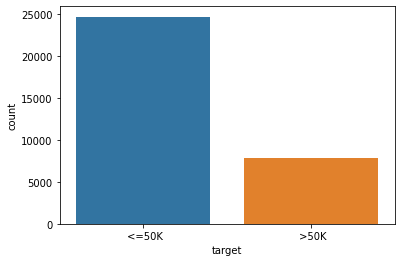

In [ ]:
## Is the dataset balanced?

sns.countplot(x= 'target', data= data)


##What is a decision tree?



*   We want to make a decision based on Questions & Answers
*   Just like in real life!



##Entropy Implementation

In [ ]:
def entropy(class_y):
    """
    Input:
      class_y: list of class labels (0's and 1's)

    Output:
      The entropy

    Compute the entropy for a list of classes.

    """ 
    if len(class_y) <=1:  ## Handling if there is only 1 or 0 labels 
        return 0 

    total_count= np.bincount(class_y) # count
    probabilities= total_count[np.nonzero(total_count)]/ len(class_y) # Find the probabilities
    if len(probabilities)<=1: # Handling if the length of the probabilities is less than or equal to 1
        return 0

    return - np.sum(probabilities * np.log(probabilities)) / np.log(len(probabilities))   # Entropy equation


#Information Gain

In [ ]:
def information_gain(previous_y, current_y):
    """
    Inputs:
      - previous_y: the distribution of ORIGINAL labels (0's and 1's)
      - current_y: the distribution of labels AFTER splitting based on a particular split attribute and split value

    Outputs:
      - info_gain: the information gain after partitioning

    Compute and return the information gain from partitioning the previous_y labels into the current_y labels.

    """
    conditional_entropy = 0 ## IG = H(Y) - CE(Y|X)  Info_gain = entropy of y MINUS the conditional entropy of y given x
    for y in current_y:
      conditional_entropy += (entropy(y) * len(y) / len(previous_y))
    
    info_gain = entropy(previous_y) - conditional_entropy
    return info_gain

#Test the information gain and the entropy implementations

In [ ]:
# TEST CASE
test_class_y = [0,0,0,1,1,1,1,1]
print(entropy(test_class_y))

previous_y = [0,0,0,1,1,1]
current_y = [[0,0] , [1,1,1,0]]
print(information_gain(previous_y , current_y))

0.954434002924965
0.4591479170272448


#The Decision Tree ID3 Algorithm

####**Iterative Dichotomiser**

1. Find best feature
2. Find best split for the best feature
3. Partition classes based on steps 1 and 2

#Step 3: Partition Classes

- One of the basic operations is to split a tree based on one attribute- step 1- with a specific value for that attribute- step 2.

- We also need to take into consideration if the split attribute is either numerical or categorical.

In [ ]:
def partition_classes(x, y, split_attribute, split_val):
  """
  Inputs:
  - x               -  (N,D) list containing all data attributes
  - y               -   a list of labels
  - split_attribute -  column index of the attribute to split on
   -split_val       -   either a numerical or categorical value to divide the split_attribute

   Outputs:
   - x_left  - x left after partitioning
   - x_right - x right after partitioning
   - y_left  - y left after partitioning
   - y_right - y right after partitioning

   Partition the data (x) and labels (y) based on the split value.
  
   Example:
   x = [[3, 'aa', 10],          y=[1,
        [1, 'bb', 22],             1,
        [2, 'cc', 28],             0,
        [5, 'bb', 32],             0,
        [4, 'cc', 32]]             1]

   Here, columns 0 and 2 represent numeric attributes, while column 1 is a categorical attribute.

   Consider the case where we call the function with split_attribute = 0 (the index of attribute) and split_val = 3.
   Then we divide x into 2 lists - x_left, where column 0 is <=3, and x_right, where column 0 is > 3

   x_left =  [[3, 'aa', 10],          y_left=[1,
              [1, 'bb', 22],                  1,
              [2, 'cc', 28]]                  0]
    

  x_right = [[5, 'bb', 32],           y_right= [0,
             [4, 'cc', 32]]                     1]

  Consider the case where we call the function with split_attribute = 1 and split_val = 'bb'.
  Then we divide x into 2 lists, one where column 1 is 'bb' and the other where it is not 'bb'.

  x_left = [[1, 'bb', 22],           y_left = [1,
            [5, 'bb', 32]]                     0]

  x_right = [[3, 'aa', 10],          y_right = [1,
             [2, 'cc', 28],                     0,
             [4, 'cc', 32]]                     1]

  
  """
  x = np.array(x)
  column_split = x[:, split_attribute]
  x_left = []
  y_right = []
  x_right = []
  y_left = []

  counter= 0 ##counter for appending

  if isinstance(split_val, str) == False: ## Numerical attribute
      for i in column_split:
          if i <= split_val:
              x_left.append(x[counter])
              y_left.append(y[counter])
          else:
              x_right.append(x[counter])
              y_right.append(y[counter])
          counter+=1

  else:   ## Categorical attribute
      for i in column_split:
        if i == split_val: ## == and NOT <=
            x_left.append(x[counter])
            y_left.append(y[counter])
        else:
            x_right.append(x[counter])
            y_right.append(y[counter])
        counter+=1

  return x_left, x_right, y_left, y_right

        


#Step 2: Find the Best Split



*   In this step we find the *order* of features splitting.
*   To do so, we calculate the information gain of each value in the attribute list.

*   Then we find the optimal split value. This corresponds to the one with the highest information gain.





In [ ]:
def find_best_split(x, y, split_attribute):
    """
    Inputs:
    - x               :  (N,D) list containing all data attributes
    - y               :   a list array of labels
    - split_attribute :  column of x on which to split

    Outputs:
    - best_split_val : optimal split value for a given attribute
    - best_info_gain : the corresponding information gain

    Compute and return the optimal split value for a given attribute, along with the corresponding information gain.
   
    Example:
    x = [[3, 'aa', 10],          y=[1,
         [1, 'bb', 22],             1,
         [2, 'cc', 28],             0,
         [5, 'bb', 32],             0,
         [4, 'cc', 32]]             1]

    split_attribute = 0

    Starting entropy = 0.971

    Calculate information gain at splits:
      split_val = 1 --> info_gain = 0.17
      split_val = 2 --> info_gain = 0.01997
      split_val = 3 --> info_gain = 0.01997
      split_val = 4 --> info_gain = 0.32
      split_val = 5 --> info_gain = 0

    best_split_val = 4 ; info_gain = .32
    """

    best_info_gain = 0  ## Initialize the best information gain
    x = np.array(x)
    column_split = x[:, split_attribute]

    column_split = np.unique(column_split)  ## Get the unique values only!
    best_split_val = column_split[0]  ## Set the best split as the initial one (in case it is the only one)

    for split_val in column_split:
        current_x_left, current_x_right, current_y_left, current_y_right = partition_classes(x, y, split_attribute, split_val)
        current_y = []
        current_y.append(current_y_left)
        current_y.append(current_y_right)

        current_info_gain = information_gain(y, current_y)  ## Calculate the information gain
        if current_info_gain > best_info_gain:  ## check if it is better than before
          best_info_gain = current_info_gain
          best_split_val = split_val

    return best_split_val, best_info_gain





#Step 1: Find Best Feature

We use steps 2 and 3 to find the best feature.

In [ ]:
def find_best_feature(x, y):
    """
    Inputs:
    - x               :  (N,D) list containing all data attributes
    - y               :   a list of labels

    Outputs:
    - best_feature   : best feature to split on
    - best_split_val : best split value for this feature

    Compute and return the optimal attribute to split on and optimal splitting value.
   
    Example:
    x = [[3, 'aa', 10],          y=[1,
         [1, 'bb', 22],             1,
         [2, 'cc', 28],             0,
         [5, 'bb', 32],             0,
         [4, 'cc', 32]]             1]


    Starting entropy = 0.971

    Calculate information gain at splits:
      feature 0: --> info_gain = 0.32
      feature 1: --> info_gain = 0.17
      feature 2: --> info_gain = 0.4199

    best_split_feature = 2 ; best_split_val = 22
    """

    best_info_gain = 0
    best_feature   = 0
    best_split_val = 0
    for feature_index in range(len(x[0])):  ## Loop over the features, find the best split.
        current_best_split_val, current_best_info_gain = find_best_split(x, y, feature_index)
        if current_best_info_gain > best_info_gain:
            best_info_gain = current_best_info_gain
            best_feature = feature_index
            best_split_val = current_best_split_val
    return best_feature, best_split_val       

#Decision Tree ID3 Full Algorithm : Putting Everything Together

We will use a recursive algorithm, so we need to have a base case- a stopping condition for splitting. It can be one of the following:


*   If all data points in that node have the same label
*   If the current node is at the maximum depth. In this case you may assign the node of the labels as the class label

We are going to use a dictionary to store the tree information. It will contain the class labels, feature and value to split, and reference to the left and right children.



In [ ]:
class MyDecisionTree(object):
    def __init__(self, max_depth=None):
        """

        Args:

        max_depth: maximum depth of the tree including the root node.
        """
        self.tree = {}
        self.residual_tree = {}  ## For prediction
        self.max_depth = max_depth

    def fit (self, x, y, depth):  
        """
        Args:
        x    : N*D matrix corresponding to the data points.
        y    : N*1 array corresponding to the labels of the data points.
        depth: depth of node of the tree.

        Output:
        node : a dictionary that contains this node information. 
        """

        ## base cases
        unique_labels = np.unique(y)
        if (len(unique_labels)==1) or (depth == max_depth): ## If we reach the maximum depth or 1
            unique_labels, counts_unique_labels = np.unique (y, return_counts=True)
            index = counts_unique_labels.argmax()
            classification = unique_labels[index]
            return classification

        best_feat, best_split = find_best_feature (x, y)  ## Find best feature (Step 1)
        x_left, x_right, y_left, y_right = partition_classes (x, y, best_feat, best_split) ## Partition on the best feature

        if isinstance (best_split, str):
            question = "{} == {}".format(best_feat, best_split) ## Represent the subtree as a question and an answer
        else:
            question = "{} <= {}".format(best_feat, best_split) ## Represent the subtree as a question and an answer
        node = {question: []}

        ## find answers (recursion)
        depth+=1
        yes_answer = self.fit(x_left, y_left, depth)  ## RECURSION on the left subtree  
        no_answer =  self.fit(x_right, y_right, depth) ## RECURSION on the right subtree 

        if yes_answer == no_answer: ## Both trees are the same
            node = yes_answer
        else:
            node[question].append(yes_answer) ## Append the questions to the answers
            node[question].append(no_answer)  
        self.tree = node ## The tree is equal to the node
        return node 
    def predict(self, record, flag=1):
        """
        Args:

        record: D*1, a single data point that should be classified.

        Output:
        prediction: True if the predicted class label is 1, False otherwise

        classify a sample in test dataset using self.tree and return the predicted label
        """
        if flag == 1: ## First time
            self.residual_tree = self.tree
        question = list(self.residual_tree.keys())[0]
        feature, comparison, value = question.split() 

        ## Check if str or int
        if comparison == "==": # String
            if record[int(feature)] == value:
                answer = self.residual_tree[question][0] ## Left subtree
            else:
                answer = self.residual_tree[question][1] ## Right subtree
        elif comparison == "<=": # Integer
            if record[int(feature)] <= float(value):
                answer = self.residual_tree[question][0] ## Right subtree
            else:
                answer = self.residual_tree[question][1] ## Left subtree

        # base case
        if not isinstance(answer, dict): ## If we have the answer
            return answer

        #recursion
        else:
            self.residual_tree = answer ## The residual tree is the answer
            return self.predict(record, 0) ## have flag=0 so the residual tree is our sub-problem                                                                 

# Evaluate the ID3 implementation

In [ ]:
def DecisionTreeEvaluation(id3, x, y, verbose=False):

    y_predicted = []
    for record in x:
        y_predicted.append(id3.predict(record))
    # Comparing predicted and true labels
    results = [prediction == truth for prediction, truth in zip(y_predicted, y)] 
    # Accuracy
    accuracy = float(results.count(True)) / float(len(results))
    if verbose:
        print("accuracy: %.4f" % accuracy)
    return accuracy       

In [ ]:
columns_names= ['age','workclass','fnlwg','education','education_num','marital_status','occupation','relationship','race','sex','capital_gain','capital_loss','hours_per_week','country','target']
df_train = pd.read_csv("adult_data.csv", header=None, names = columns_names)
df_train.drop(columns = "fnlwg", inplace=True)
df_train.head()
                      


,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,country,target
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
columns_names= ['age','workclass','fnlwg','education','education_num','marital_status','occupation','relationship','race','sex','capital_gain','capital_loss','hours_per_week','country','target']
df_test = pd.read_csv("adult_test.csv", names = columns_names)
df_test.drop(columns = "fnlwg", inplace=True)
df_test.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,country,target
0,|1x3 Cross validator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,Private,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.


In [ ]:
df_test = df_test.iloc[1:]
df_test.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,country,target
1,25,Private,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.
5,18,?,Some-college,10.0,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States,<=50K.


In [ ]:
df_test["age"] = pd.to_numeric(df_test["age"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
x_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]
print(y_train.head())
label_enc = LabelEncoder()
y_train = label_enc.fit_transform(y_train)
print(y_train)

0     <=50K
1     <=50K
2     <=50K
3     <=50K
4     <=50K
Name: target, dtype: object
[0 0 0 ... 0 0 1]


In [ ]:
x_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

label_enc = LabelEncoder()
y_test = label_enc.fit_transform(y_test)
y_test

array([0, 0, 1, ..., 0, 0, 1])

In [ ]:
### Convert the dataframes to numpy arrays as our implementation works on NumPy arrays
x_train, x_test = x_train.to_numpy(), x_test.to_numpy()
max_depth = 3
initial_depth = 0
id3_dt  = MyDecisionTree(max_depth)
# Building a tree
print("fitting the decision tree")
id3_dt.fit(x_train, y_train, initial_depth)

# Evaluating the decision tree
DecisionTreeEvaluation(id3_dt, x_test, y_test, True)



fitting the decision tree
accuracy: 0.8031


0.8030833486886555

##What is the final tree 

In [ ]:
id3_dt.tree

{'4 ==  Married-civ-spouse': [{'3 <= 12': [{'9 <= 5013': [0, 1]}, 1]},
  {'9 <= 6849': [0, {'0 <= 20': [0, 1]}]}]}